## E-Commerce User Behavior Analysis and Recommendation System

This project focuses on analyzing real-world e-commerce interaction data to improve recommendation systems and detect abnormal browsing behavior.  
We will follow the **CRISP-DM** framework to ensure a structured approach.

**Objectives:**
1. **Predict item properties** (such as price range, vendor, and product type) for products added to cart, using patterns from the same user's prior view events.
2. **Detect abnormal users** whose browsing patterns significantly deviate from normal behavior, in order to:
   - Reduce noise and bias in the recommendation system.
   - Improve the accuracy of split testing and overall analytics.

The workflow includes:
- Business understanding and formulation of analytical questions.
- Extensive data exploration and preprocessing.
- Visualization of behavioral trends.
- Machine learning modeling for both property prediction and anomaly detection.
- Actionable recommendations for business decision-making.


In [1]:
%pip install squarify

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2610394 sha256=905c13ba2bea23d88a60c57b10c1787fc19751469468837521d5c88556776ec3
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [3]:
!pip install numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import math
import squarify
import os
import duckdb
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,roc_curve
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from scipy import sparse
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from scipy.sparse import csr_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import psutil, os
from tqdm import tqdm


from time import time

from scipy.stats import randint
import random

from warnings import simplefilter
simplefilter("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# List the contents of the specified Google Drive folder
!ls "/content/drive/My Drive/Colab Data/TMP"

'About Recommendation System Dataset.pdf'    item_properties_part1.1.csv
 category_tree.csv			     item_properties_part2.csv
'Copy Property_Recommendation-Copy1.ipynb'   Property_Recommendation.ipynb
 events.csv


In [5]:
os.chdir('/content/drive/My Drive/Colab Data/TMP')

!pwd

/content/drive/My Drive/Colab Data/TMP


### Exploratory Data Analysis (EDA)
Understanding Data Structure

In [6]:
events = pd.read_csv("events.csv")
item_prop01 = pd.read_csv("item_properties_part1.1.csv")
item_prop02 = pd.read_csv("item_properties_part2.csv")
category_tree = pd.read_csv("category_tree.csv")

print("EVENTS TABLE:")
display(events.head())
print("\nITEM PROPERTIES 1 TABLE:")
display(item_prop01.head())
print("\nITEM PROPERTIES 2 TABLE:")
display(item_prop02.head())
print("\nCATEGORY TREE TABLE:")
display(category_tree.head())

EVENTS TABLE:


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN



ITEM PROPERTIES 1 TABLE:


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513



ITEM PROPERTIES 2 TABLE:


,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062



CATEGORY TREE TABLE:


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [7]:
print("Events shape:", events.shape)
print("Item Props 1 shape:", item_prop01.shape)
print("Item Props 2 shape:", item_prop02.shape)
print("Category Tree shape:", category_tree.shape)

Events shape: (2756101, 5)
Item Props 1 shape: (10999999, 4)
Item Props 2 shape: (9275903, 4)
Category Tree shape: (1669, 2)


In [8]:
# Concatenate item_prop1 and item_prop2
item_prop1 = pd.concat([item_prop01, item_prop02], axis=0, ignore_index=True)

# Preview result
print("Shape of concatenated dataframe:", item_prop1.shape)
print(item_prop1.head())


Shape of concatenated dataframe: (20275902, 4)
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513


### Preprocessing & Cleaning

In [9]:
# Convert timestamps to human-readable dates
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
print(events['event'].value_counts())

# Transaction ID only for purchases
print(events[events['event'] == 'transaction']['transactionid'].notna().mean())

# Summary statistics for events
events_summary = events.groupby('event')['itemid'].count().reset_index()
events_summary.columns = ['event', 'count']

print(events_summary)


event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64
1.0
         event    count
0    addtocart    69332
1  transaction    22457
2         view  2664312


In [10]:
# Convert timestamp column from milliseconds to datetime
item_prop1['date'] = pd.to_datetime(item_prop1['timestamp'], unit='ms')


In [11]:
print(events.isna().sum())

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
datetime               0
dtype: int64


In [12]:
events[['timestamp', 'datetime']].head(10)

,timestamp,datetime
0,1433221332117,2015-06-02 05:02:12.117
1,1433224214164,2015-06-02 05:50:14.164
2,1433221999827,2015-06-02 05:13:19.827
3,1433221955914,2015-06-02 05:12:35.914
4,1433221337106,2015-06-02 05:02:17.106
5,1433224086234,2015-06-02 05:48:06.234
6,1433221923240,2015-06-02 05:12:03.240
7,1433223291897,2015-06-02 05:34:51.897
8,1433220899221,2015-06-02 04:54:59.221
9,1433221204592,2015-06-02 05:00:04.592


In [13]:
# Convert timestamp
item_prop1['datetime'] = pd.to_datetime(item_prop1['timestamp'], unit='ms')

# Check property types
print(item_prop1['property'].value_counts().head(20))

property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
283            597419
776            574220
678            481966
364            476486
202            448938
839            417239
917            417227
764            417053
159            417053
112            417053
227            347492
698            289849
451            264416
663            240813
962            239372
Name: count, dtype: int64


In [14]:
# Check missing values
print(item_prop1.isna().sum())

timestamp    0
itemid       0
property     0
value        0
date         0
datetime     0
dtype: int64


In [20]:
# Check how many rows in 'value' start with 'n'
n_count = item_prop1['value'].astype(str).str.startswith('n').sum()

# Total rows in the dataframe
total_count = len(item_prop1)

# Percentage
percentage = (n_count / total_count) * 100

print(f"Total rows: {total_count}")
print(f"Rows starting with 'n': {n_count}")
print(f"Percentage: {percentage:.2f}%")


Total rows: 20275902
Rows starting with 'n': 3248611
Percentage: 16.02%


In [15]:
mask_numeric = item_prop1['value'].apply(lambda x: isinstance(x, (int, float)))
mask_non_n = item_prop1['value'].astype(str).str.contains('n', case=False, na=False) == False

item_prop1 = item_prop1[mask_numeric | mask_non_n].copy()

# 2. Convert all remaining values to numeric (non-convertible become NaN, then drop)
item_prop1['value'] = pd.to_numeric(item_prop1['value'], errors='coerce')

# 3. Drop rows where conversion failed
item_prop1 = item_prop1.dropna(subset=['value']).reset_index(drop=True)

In [22]:
item_prop1.head(20)

,timestamp,itemid,property,value,date,datetime
0,1435460400000,460429,categoryid,1338.0,2015-06-28 03:00:00,2015-06-28 03:00:00
1,1431831600000,156781,917,828513.0,2015-05-17 03:00:00,2015-05-17 03:00:00
2,1436065200000,285026,available,0.0,2015-07-05 03:00:00,2015-07-05 03:00:00
3,1434250800000,89534,213,1121373.0,2015-06-14 03:00:00,2015-06-14 03:00:00
4,1431831600000,264312,6,319724.0,2015-05-17 03:00:00,2015-05-17 03:00:00
5,1433646000000,229370,202,1330310.0,2015-06-07 03:00:00,2015-06-07 03:00:00
6,1437274800000,186518,available,0.0,2015-07-19 03:00:00,2015-07-19 03:00:00
7,1436670000000,319291,888,1292080.0,2015-07-12 03:00:00,2015-07-12 03:00:00
8,1431226800000,344365,159,519769.0,2015-05-10 03:00:00,2015-05-10 03:00:00
9,1434250800000,269797,159,519769.0,2015-06-14 03:00:00,2015-06-14 03:00:00


In [16]:
# Start from events
events_merged = events.copy()

#  Bring categoryid from item_properties
category_info = item_prop1[item_prop1['property'] == 'categoryid'][['itemid', 'value']]
category_info = category_info.rename(columns={'value': 'categoryid'})

# Merge events with categoryid
events_merged = events_merged.merge(category_info, on='itemid', how='left')

# Ensure both categoryid columns are the same type
events_merged['categoryid'] = events_merged['categoryid'].astype(str)
category_tree['categoryid'] = category_tree['categoryid'].astype(str)

# Merge with category_tree to add category names/hierarchy
events_merged = events_merged.merge(category_tree, on='categoryid', how='left')

# Preview
print(events_merged.head())


       timestamp  visitorid event  itemid  transactionid  \
0  1433221332117     257597  view  355908            NaN   
1  1433224214164     992329  view  248676            NaN   
2  1433221999827     111016  view  318965            NaN   
3  1433221955914     483717  view  253185            NaN   
4  1433221337106     951259  view  367447            NaN   

                 datetime categoryid  parentid  
0 2015-06-02 05:02:12.117     1173.0       NaN  
1 2015-06-02 05:50:14.164     1231.0       NaN  
2 2015-06-02 05:13:19.827        nan       NaN  
3 2015-06-02 05:12:35.914      914.0       NaN  
4 2015-06-02 05:02:17.106     1613.0       NaN  


In [17]:
# Number of unique items
print("Unique items:", item_prop1['itemid'].nunique())

Unique items: 417053


In [18]:
# Example: availability over time
availability = item_prop1[item_prop1['property'] == 'available']
availability['datetime'] = pd.to_datetime(availability['timestamp'], unit='ms')
availability['value'] = availability['value'].astype(int)
print(availability['value'].value_counts())

# Price-related properties (look for 'n' prefix)
price_data = item_prop1[item_prop1['value'].astype(str).str.startswith('n')]
print(price_data.head())

value
0    863086
1    640553
Name: count, dtype: int64
Empty DataFrame
Columns: [timestamp, itemid, property, value, date, datetime]
Index: []


In [19]:
# Check if category hierarchy is valid
print(category_tree.isna().sum())

categoryid     0
parentid      25
dtype: int64


In [20]:
print("Unique categories:", category_tree['categoryid'].nunique())

Unique categories: 1669


### Data Analysis & Bussiness Questions
1. Event distribution →
"What proportion of customer interactions are views, additions to cart, or purchases?"

2. Events over time →
"Do customer interactions show seasonal trends, weekly patterns, or sudden spikes that could indicate campaigns or issues?"

3. Top viewed items →
"Which products generate the most interest from customers?"

4. Availability trend →
"Has product availability improved or worsened over time, and could this be impacting sales?"

5. Category popularity →
"Which product categories attract the most attention from customers?"

6. Conversion funnel performance →
"What percentage of views convert into purchases, and which events lose the most customers?"

8. High-value transaction analysis →
"Which products or categories contribute most to total revenue?"

#### 1. Events Distribution

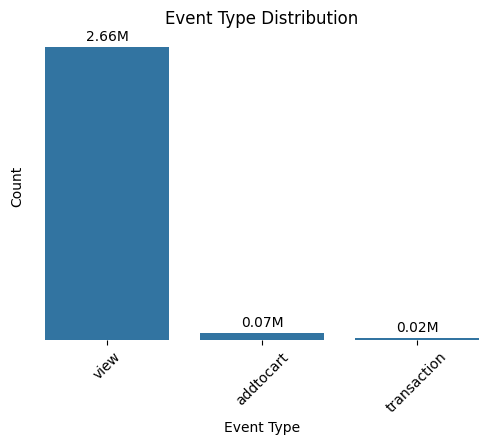

In [21]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=events, x='event', order=events['event'].value_counts().index)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")

# Add labels with billions format (adjust as needed)
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f'{v.get_height()/1e6:.2f}M' for v in container],  # comma-separated integers
        label_type='edge',
        padding=2
    )

plt.xticks(rotation=45)
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()


#### Event over time

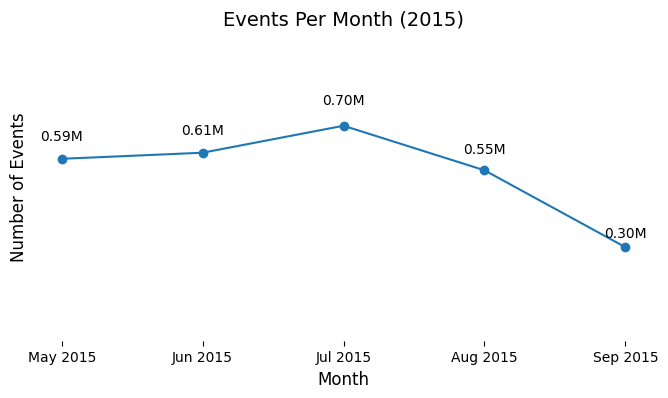

In [22]:
# Group by month
events_monthly = events.groupby(events['datetime'].dt.to_period('M')).size()

# Convert index to string labels (e.g., "2015-06")
months = events_monthly.index.strftime('%b %Y')

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(months, events_monthly.values, marker='o', linestyle='-')

# Labels & title
ax.set_title("Events Per Month (2015)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Number of Events", fontsize=12)

# Add labels with offset
offset = 0.10
for i, val in enumerate(events_monthly.values):
    ax.text(i, val + offset * val, f"{val/1e6:.2f}M", ha='center', fontsize=10)

# Remove surrounding border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove grid
ax.grid(False)
ax.set_ylim(0,1e6)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
plt.show()


#### Top 10 Most Viewed Items

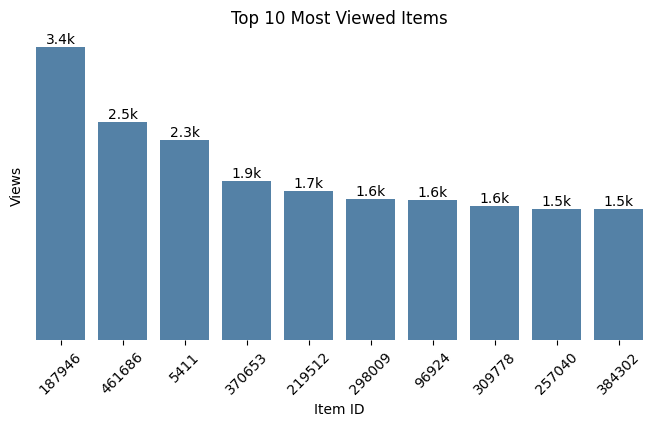

In [23]:
def add_bar_labels(ax):
    for p in ax.patches:
        value = p.get_height()
        label = f'{value/1000:.1f}k'  # ✅ rounded to 1 decimal in thousands
        ax.annotate(label,
                    (p.get_x() + p.get_width()/2, value),
                    ha='center', va='bottom')

# Plot
top_viewed_items = events[events['event'] == 'view']['itemid'].value_counts().head(10)

plt.figure(figsize=(8,4))
ax = sns.barplot(x=top_viewed_items.index.astype(str),
                 y=top_viewed_items.values,
                 color="steelblue")

plt.title("Top 10 Most Viewed Items")
plt.xlabel("Item ID")
plt.ylabel("Views")

add_bar_labels(ax)  #  labels like "12.3k"

plt.xticks(rotation=45)
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()


#### Category Distribution

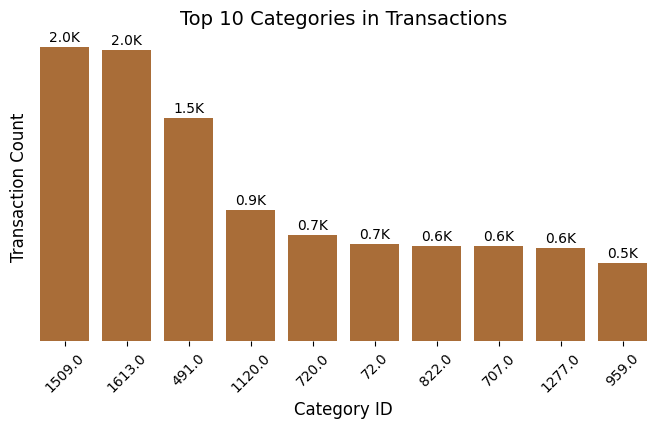

In [24]:
# Merge events with categoryid first
category_info = item_prop1[item_prop1['property'] == 'categoryid'][['itemid', 'value']]
category_info = category_info.rename(columns={'value': 'categoryid'})

# Ensure both categoryid columns are the same type before merging
events['itemid'] = events['itemid'].astype(str)
category_info['itemid'] = category_info['itemid'].astype(str)
category_info['categoryid'] = category_info['categoryid'].astype(str)


events_merged = events.merge(category_info, on='itemid', how='left')

# Now filter for transactions from the merged data
transactions = events_merged[events_merged["event"] == "transaction"].copy()

# --- 2. Get price info from item properties
prices = item_prop1[item_prop1["property"] == "price"].copy()
prices["value"] = pd.to_numeric(prices["value"], errors="coerce")

# Ensure itemid is string for merging with prices
prices['itemid'] = prices['itemid'].astype(str)

# --- 3. Merge transactions with price
tx_price = transactions.merge(prices[["itemid", "value"]],
                              on="itemid", how="left")
tx_price.rename(columns={"value": "price"}, inplace=True)

# --- 4. Compute revenue by product
product_revenue = tx_price.groupby("itemid")["price"].sum().reset_index()

# --- 5. Get category mapping (already done in the first merge, but keeping this for potential future use or clarity)
categories = item_prop1[item_prop1["property"] == "categoryid"][["itemid", "value"]]
categories.rename(columns={"value": "categoryid"}, inplace=True)

# Ensure itemid is string for merging
categories['itemid'] = categories['itemid'].astype(str)

# Merge category information into product_revenue
product_revenue = product_revenue.merge(categories, on="itemid", how="left") # This merge is now redundant for categoryid

# Ensure categoryid is string and handle potential NaNs before grouping
product_revenue['categoryid'] = product_revenue['categoryid'].astype(str).fillna('Unknown')


# --- 6. Aggregate by category
category_revenue = product_revenue.groupby("categoryid")["price"].sum().reset_index()
category_revenue = category_revenue.sort_values("price", ascending=False)

# Count top 10
category_counts_tx = transactions['categoryid'].value_counts().head(10)

# Convert to DataFrame for plotting
category_counts_tx = category_counts_tx.reset_index()
category_counts_tx.columns = ['categoryid', 'count']

# Plot in descending order
plt.figure(figsize=(8,4))
ax = sns.barplot(
    x='categoryid',
    y='count',
    data=category_counts_tx,
    order=category_counts_tx.sort_values('count', ascending=False)['categoryid'],  # ✅ ensures descending order
    color='#BC6C25'
)

plt.title("Top 10 Categories in Transactions", fontsize=14)
plt.xlabel("Category ID", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)

# Add labels in thousands
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f'{v.get_height()/1e3:.1f}K' for v in container],
        label_type='edge',
        padding=2
    )

plt.xticks(rotation=45)
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

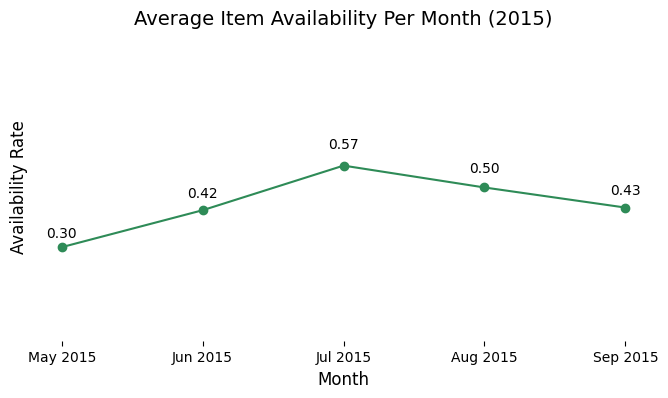

In [25]:
# Group by month
availability['datetime'] = pd.to_datetime(availability['timestamp'], unit='ms')

availability_monthly = availability.groupby(availability['datetime'].dt.to_period('M'))['value'].mean()

# Convert index to string labels (e.g., "2015-06")
months = availability_monthly.index.strftime('%b %Y')

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(months, availability_monthly.values, marker='o', linestyle='-', color='seagreen')

# Labels & title
ax.set_title("Average Item Availability Per Month (2015)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Availability Rate", fontsize=12)

# Add labels with offset
offset = 0.10
for i, val in enumerate(availability_monthly.values):
    ax.text(i, val + offset * val,f"{val:.2f}", ha='center', fontsize=10)
# Remove surrounding border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove grid
ax.grid(False)
ax.set_ylim(0,1)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
plt.show()


#### Conversion funnel performance

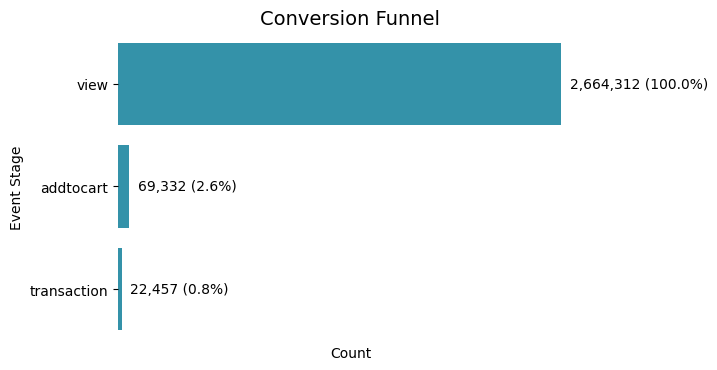

In [31]:
funnel_counts = events['event'].value_counts()
funnel_order = ['view', 'addtocart', 'transaction']

# Keep only the funnel events in the correct order
funnel_counts = funnel_counts.reindex(funnel_order)

# Step 2: Calculate percentages
funnel_percentages = (funnel_counts / funnel_counts.iloc[0]) * 100

# Step 3: Plot horizontal funnel
plt.figure(figsize=(6,4))
ax = sns.barplot(
    y=funnel_counts.index,
    x=funnel_counts.values,
    order=funnel_order,
    color='#219ebc'
)

# Titles and labels
plt.title("Conversion Funnel", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Event Stage")

# Add data labels (count + %)
for i, v in enumerate(funnel_counts.values):
    ax.text(
        v + (0.02 * funnel_counts.max()),  # small horizontal offset
        i,
        f"{v:,} ({funnel_percentages.iloc[i]:.1f}%)",
        va='center',
        fontsize=10
    )

# Remove x-axis ticks & borders
plt.xticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


#### High-value transaction analysis

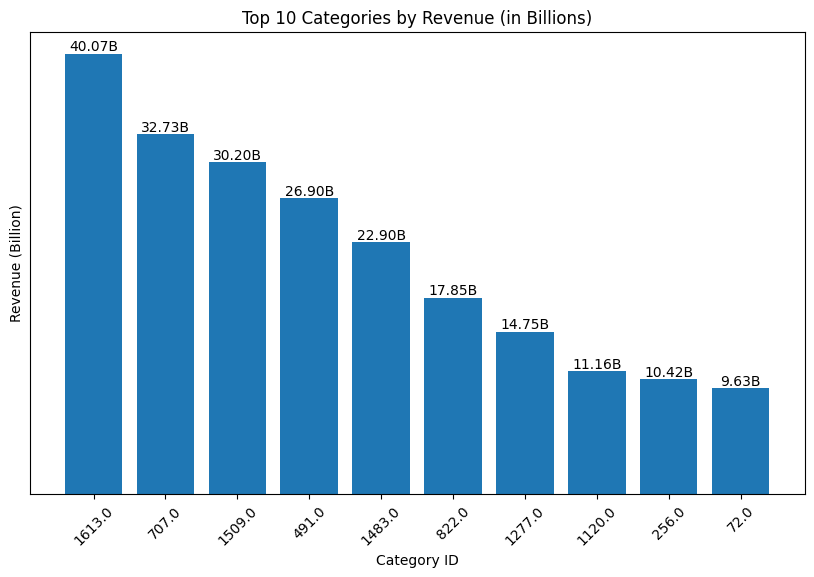

In [28]:
transactions = events[events["event"] == "transaction"].copy()

# --- 2. Get price info from item properties
prices = item_prop1.copy()
prices["value"] = pd.to_numeric(prices["value"], errors="coerce")

# Ensure itemid is string for merging with prices
transactions['itemid'] = transactions['itemid'].astype(str)
prices['itemid'] = prices['itemid'].astype(str)


# --- 3. Merge transactions with price
tx_price = transactions.merge(prices[["itemid", "value"]],
                              on="itemid", how="left")
tx_price.rename(columns={"value": "price"}, inplace=True)

# --- 4. Compute revenue by product
product_revenue = tx_price.groupby("itemid")["price"].sum().reset_index()

# --- 5. Get category mapping
categories = item_prop1[item_prop1["property"] == "categoryid"][["itemid", "value"]]
categories.rename(columns={"value": "categoryid"}, inplace=True)

# Ensure itemid is string for merging categories
product_revenue['itemid'] = product_revenue['itemid'].astype(str)
categories['itemid'] = categories['itemid'].astype(str)

product_revenue = product_revenue.merge(categories, on="itemid", how="left")

# --- Ensure categoryid is string and handle potential NaNs before grouping
# Explicitly filter out rows where categoryid is NaN before converting to string and filling
product_revenue = product_revenue[product_revenue['categoryid'].notna()].copy()
product_revenue['categoryid'] = product_revenue['categoryid'].astype(str)


# --- 6. Aggregate by category
category_revenue = product_revenue.groupby("categoryid")["price"].sum().reset_index()
category_revenue = category_revenue.sort_values("price", ascending=False)


# --- Scale revenue to billions
category_revenue["price_billion"] = category_revenue["price"] / 1e9

# --- Plot Top 10 categories
plt.figure(figsize=(10,6))
bars = plt.bar(category_revenue["categoryid"].astype(str)[:10],
               category_revenue["price_billion"][:10])

plt.xlabel("Category ID")
plt.ylabel("Revenue (Billion)")
plt.title("Top 10 Categories by Revenue (in Billions)")
plt.xticks(rotation=45)

# --- Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{height:.2f}B", ha="center", va="bottom", fontsize=10)
plt.xticks(rotation=45)
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

### MODEL BUILDING

#### Recommenders aligned to goals

-1) Personalized recommendations → Item-Item CF, SVD MF.

-2) Diverse use cases → Popularity + Content + CF + Hybrid.

-3) Utilize historical data → time-based split, implicit weights.

-4) Enhance engagement → relevance metrics + MMR diversification.

-5) Scalability/real-time → sparse ops, precomputed sims, simple APIs.

-6) Boost business metrics → can weight by value/price.

-7) Balance accuracy & diversity → MMR re-ranking.

#### Collaborative Filtering (ALS, Sparse Only)

In [32]:
item_prop1["encoded"] = (
    item_prop1
    .groupby("property")["value"]
    .transform(lambda col: LabelEncoder().fit_transform(col.astype(str)))
)

# Keep itemid + property + encoded so you can pivot later
item_features = item_prop1[["itemid", "property", "encoded"]]

# Pivot to ML-ready wide format (sparse if you use SparseDtype)
item_features_wide = (
    item_features
    .pivot_table(index="itemid", columns="property", values="encoded", fill_value=0)
    .astype("Sparse[int]")
    .reset_index()
)

In [36]:
item_features.head()

,itemid,property,encoded
0,460429,categoryid,273
1,156781,917,187221
2,285026,available,0
3,89534,213,0
4,264312,6,485


In [34]:
# Map events into implicit feedback scores
feedback_map = {"view": 1, "addcart": 2, "transaction": 3}
events["interaction"] = events["event"].map(feedback_map)

# Keep only the columns needed for CF
interactions = events[["visitorid", "itemid", "interaction"]].dropna()



In [35]:
item_features_pivot = (
    item_features
    .pivot_table(index="itemid",
                 columns="property",
                 values="encoded",
                 aggfunc="first")  # or 'mean'/'mode' if multiple
    .reset_index()
)


In [36]:
print(interactions.columns.tolist())
print(item_features.columns.tolist())


['visitorid', 'itemid', 'interaction']
['itemid', 'property', 'encoded']


In [39]:
print(interactions["itemid"].dtype)
print(item_features["itemid"].dtype)


int64
int64


In [38]:
interactions['itemid'] = pd.to_numeric(interactions['itemid'], errors='coerce')
item_features['itemid'] = pd.to_numeric(item_features['itemid'], errors='coerce')

In [53]:
# Drop exact duplicates
interactions = interactions.drop_duplicates()
item_features = item_features.drop_duplicates()


# Drop duplicates on visitorid + itemid (keep first)
interactions = interactions.drop_duplicates(subset=['visitorid', 'itemid'])


In [54]:
n_per_class = 5000   # adjust based on your RAM

# Sample equal number of rows from each interaction type
interactions_sample = (
    interactions.groupby("interaction", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_per_class), random_state=42))
)

In [55]:
# Get itemids present in the sample
sample_itemids = interactions_sample['itemid'].unique()

# Filter item_features to only those items
item_features_sample = item_features[item_features['itemid'].isin(sample_itemids)]


In [56]:
sample_merged = interactions_sample.merge(
    item_features_sample,
    on="itemid",
    how="left"
)
sample_merged.head()

,visitorid,itemid,interaction,property,encoded
0,398390,92625,1.0,988,0.0
1,398390,92625,1.0,839,2085.0
2,398390,92625,1.0,765,7.0
3,398390,92625,1.0,231,0.0
4,398390,92625,1.0,819,2.0


In [59]:
user_item_matrix = sample_merged.pivot_table(
    index="visitorid",
    columns="itemid",
    values="interaction",
    aggfunc="count"
).fillna(0)


### Train-Test Split

In [1]:
train, test = train_test_split(interactions, test_size=0.2, random_state=42)

# Rebuild sparse matrix for train only
train_sparse = sparse.csr_matrix(
    (train['interaction'], (train['visitorid'], train['itemid']))
)
test_sparse = sparse.csr_matrix(
    (test['interaction'], (test['visitorid'], test['itemid']))
)

NameError: name 'train_test_split' is not defined

In [70]:
sparse_matrix = sp.csr_matrix(user_item_matrix.values)

model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)
model.fit(train_sparse.T)

NameError: name 'implicit' is not defined

#### Evaluation Pipeline

In [66]:
def precision_at_k(model, user_items, user_id, k=10):
    # Get user's row
    user_row = user_items[user_id]

    # New versions of implicit return two arrays
    try:
        recommended, scores = model.recommend(user_id, user_row, N=k)
    except ValueError:
        # fallback for older versions returning tuples
        recommended = [i for i, _ in model.recommend(user_id, user_row, N=k)]

    # Get relevant items (ground truth)
    relevant = set(user_row.indices)

    # Convert recommended list properly
    if isinstance(recommended, tuple) or isinstance(recommended, list):
        if isinstance(recommended[0], tuple):  # older versions
            recommended_items = set([i for i, _ in recommended])
        else:  # newer versions
            recommended_items = set(recommended)
    else:
        recommended_items = set()

    # If no ground truth, skip
    if not relevant:
        return 0.0

    # Precision@K
    return len(recommended_items & relevant) / float(k)

In [67]:
precisions = []
for user_id in range(min(500, sparse_matrix.shape[0])):  # limit to 500 users for speed
    precisions.append(precision_at_k(model, sparse_matrix, user_id, k=10))

print("Mean Precision@10:", np.mean(precisions))


Mean Precision@10: 0.0
